# EDA и разбиение на train/test

Записи имеют метку времени, но не упорядочены по времени. Отсортируем записи хронологически.

In [2]:
%load_ext pycodestyle_magic
%pycodestyle_on

In [11]:
from math import ceil

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

Необходимые определения

In [12]:
def draw_distribution_of_votes(counts: pd.Series):
    frequency_series = counts.value_counts()
    frequency_series.index.name = None # remove the existing index name
    frequency_df = frequency_series.reset_index()
    frequency_df.columns = ['count', 'total']
    frequency_df = frequency_df.sort_values('count')

    plt.figure(figsize=(12, 6))
    sns.barplot(data=frequency_df, x='count', y='total', color='skyblue')
    plt.xlabel('Count of votes')
    plt.ylabel('Total users')
    plt.title('Histogram of Total Frequencies per Count')
    plt.xticks(rotation=90) # rotate x-axis labels
    plt.yscale('log')
    plt.tight_layout()
    plt.show()

Загрузим данные

In [13]:
df = pd.read_csv('Software.csv',
                 header=None,
                 names=['item', 'user', 'rating', 'timestamp'])
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')

# Для разбиения на train/test важна правильная хронология.
df = df.sort_values('timestamp')

In [14]:
print(df.head())

              item            user  rating  timestamp
413424  0671573535  A1I7E79WGWUP6Y     1.0 1998-12-04
365283  0877794618  A2X1Z3WFRUZPC9     5.0 1999-03-14
3883    B00002SV6E  A25S30QL8ZIOPB     5.0 1999-06-18
400846  1559404779  A3KDTS7917RNBA     4.0 1999-10-23
2893    B00000K4CS   AYUD25NRJTE4M     1.0 1999-11-10


In [10]:
print("Товаров: \t", len(df.item.unique()))
print("Покупателей: \t", len(df.user.unique()))
print("Данные за период:",
      f"от {df.timestamp.min():%Y-%m-%d}",
      f"по {df.timestamp.max():%Y-%m-%d}.")
print("Пропуски данных")
print(df.isnull().sum())

Товаров: 	 21663
Покупателей: 	 375147
Данные за период: от 1998-12-04 по 2018-10-02.
Пропуски данных
item         0
user         0
rating       0
timestamp    0
dtype: int64


<Axes: xlabel='rating', ylabel='Count'>

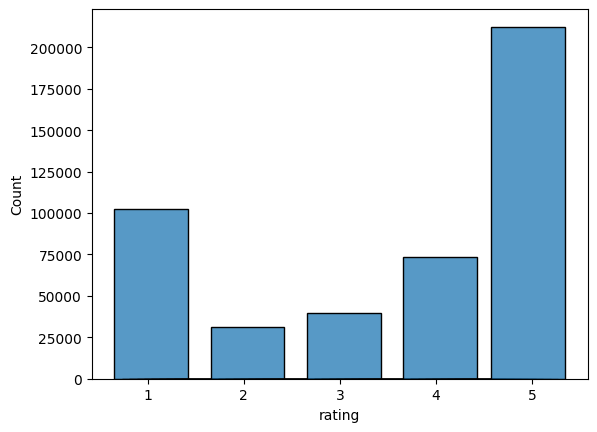

In [6]:
sns.histplot(data=df, x="rating", shrink=10)

In [15]:
counts_votes = df.value_counts('user')
votes_more_one = counts_votes[counts_votes.gt(1)].sum() / len(df)
print("Доля пользователей, кто проголосовал более одного раза:", end=' ')
print(f"{100 * votes_more_one:.0f} %.")

Доля пользователей, кто проголосовал более одного раза: 29 %.


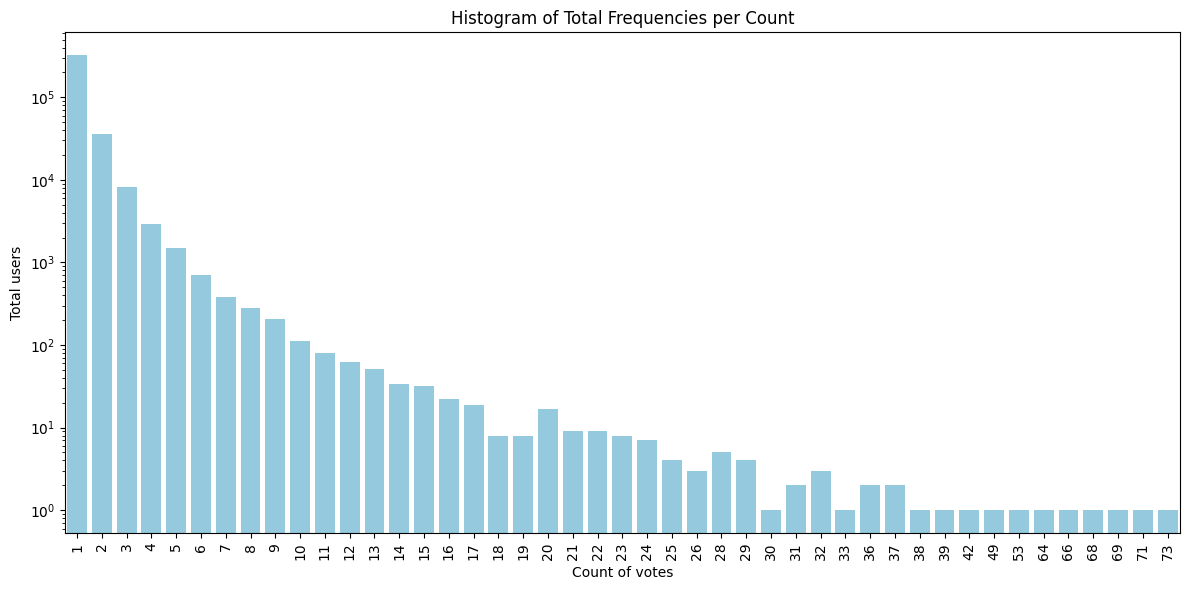

In [16]:
draw_distribution_of_votes(counts_votes)

## Leave-one-out разбиение данных на train и test

In [17]:
def split_to_train_if_more_one(x):
    """ Отделить элементы для train только, если оценок больше одной. """
    return x[:-1] if len(x) > 1 else x


def split_to_test_if_more_one(x):
    """ Отделить элементы для test только, если оценок больше одной. """
    return x[-1:] if len(x) > 1 else None


def train_test_split_leave_one_out(X, is_sorted: bool):
    """
    Разделить набор данных на train и test подмножества.
    Данная функция отделяет из оценок каждого пользователя
    последнюю в test, если пользователь сделал > 1 оценок.
    """
    if not is_sorted:
        # сортируем данные по времени
        X.sort_values(by=['timestamp'], inplace=True)

    # создаем список товаров для каждого пользователя
    items = X.groupby(['user'], sort=False)['item']\
             .apply(lambda x: list(x)).reset_index()
    # создаем список рейтингов для каждого пользователя
    ratings = X.groupby(['user'], sort=False)['rating']\
               .apply(lambda x: list(x)).reset_index()
    X = items.merge(ratings)

    train = pd.DataFrame(X['user'])
    # отделяем все кроме последнего товара в train
    train['item'] = X.item.apply(split_to_train_if_more_one)
    # отделяем все кроме последнего рейтинги в train
    train['rating'] = X.rating.apply(split_to_train_if_more_one)
    train = train.explode(['item', 'rating'])

    test = pd.DataFrame(X['user'])
    # отделяем последний товар в test
    test['item'] = X.item.apply(split_to_test_if_more_one)
    # отделяем последний рейтинг в test
    test['rating'] = X.rating.apply(split_to_test_if_more_one)
    test = test.explode(['item', 'rating'])

    test = test[test['rating'].notna()]

    return train, test


def train_test_split_complex(X: pd.core.frame.DataFrame,
                             min_test_size: float,
                             min_level: float):
    """
    Разделить набор данных на train и test подмножества.
    Сочетает логику Leave One Out и обычное случайное разделение:
    если недобрали объём тестового подмножества методом Leave-One-Out,
    то добираем простым случайным разбиением.
    Args:
        X (pandas DataFrame): dataframe.
        min_test_size (float): minimal relative size of a test subset.
        min_level (float): минимальный уровень rating для тестового набора.

    Returns:
        (pandas DataFrame, pandas DataFrame): (train, test) subsets 
    """
    train, test = train_test_split_leave_one_out(X, is_sorted=True)

    # Мы предсказываем товары, которые должны понравиться,
    # поэтому оценивать будем только на товарах
    # с высоким рейтингом от пользователя.

    test = test[test['rating'] >= min_level]

    print(f"Expected minimal test size: \t{min_test_size:.3f}")
    leave_one_out_test_size = len(test) / (len(train) + len(test))
    print(f"Leave One Out test subset size: {leave_one_out_test_size:.3f}")

    if leave_one_out_test_size < min_test_size:
        # Если недобрали объём тестового подмножества методом Leave-One-Out,
        # то добираем из последних событий по хронологии.
        train_by_min_level = train[train['rating'] >= min_level]

        test_size = ceil(min_test_size * (len(train) + len(test))) - len(test)

        train_2 = train_by_min_level.iloc[0:-test_size]
        test_2 = train_by_min_level.iloc[-test_size:]

        test = pd.concat([test, test_2])
        train = pd.concat([train[train['rating'] < min_level], train_2])
        
    print(f"Total test subset size: \t{len(test)/(len(train)+len(test)):.3f}")

    return train, test

In [18]:
train, test = train_test_split_complex(
    df,
    min_test_size=0.125,
    min_level=5.0)

# test = test.sort_values('user') 

print(f"Size of train: {len(train)}", train.head(), sep="\n")
print(f"Size of test:  {len(test)}", test.head(), sep="\n")

Expected minimal test size: 	0.125
Leave One Out test subset size: 0.057
Total test subset size: 	0.125
Size of train: 378850
              user        item rating
0   A1I7E79WGWUP6Y  0671573535    1.0
3   A3KDTS7917RNBA  1559404779    4.0
4    AYUD25NRJTE4M  B00000K4CS    1.0
8    A1G0RWUE33DTF  B00000K4CS    2.0
11  A1G19N2MZYW5AS  B00002JV62    1.0
Size of test:  54122
              user        item rating
18  A18A2Q0UNZU1LQ  B00FFINUJK    5.0
55  A1U9LTA3EWSNY1  B00006OAQU    5.0
56  A1KJ94X41TJLX0  B00005JYC3    5.0
85  A2ZRNN0L6XI9AM  B000Z3DXT2    5.0
98  A2QQR1OJE3YDH1  B00002R2AC    5.0


In [19]:
train.to_csv(".\\train.csv", index=False)
test.to_csv(".\\test.csv", index=False)

Мы разделили набор данных и сохранили в файлы: train.csv, test.csv.